In [19]:
import pandas as pd
import numpy as np
import urllib.request
import cv2
import time
import gc
import re

import scipy
import scipy.misc
import scipy.cluster

from PIL import Image

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift

# Silence warnings
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [35]:
df = pd.read_csv('data/corpus_meta.csv').drop(columns = 'Unnamed: 0')

In [36]:
df.head(1)

,index,date,longitude,latitude,image_direct_url,colored,shape_ratio,verticality,horizontality,hue,saturation,value,extracted,aws_path
0,10000979206,2013-09-30 00:26:09.0,14.499968,46.053249,http://farm4.staticflickr.com/3702/10000979206...,1.0,1.0,12.854769,15.17386,70.0,14.0,56.0,1,48e399bc1c28aebb343369d37568b


In [5]:
def url_to_image(url, suffix = 'm'):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    
    url_ = url[:-4] + '_' + suffix + url[-4:]
    
    try:
        resp = urllib.request.urlopen(url)
    except:
        return np.zeros((1,1))
    
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
    # return the image
    return image

In [6]:
def get_dominant_color(array, N_pixels):
    
    array = array.reshape(N_pixels, 3).astype(float)
    
    codes, dist = scipy.cluster.vq.kmeans(array, 3)
    vecs, dist = scipy.cluster.vq.vq(array, codes)
    counts, bins = scipy.histogram(vecs, len(codes))
    
    score = counts.astype('float')
    index_max = scipy.argmax(score)
    main_color = codes[index_max]
    h, s, v = bgr2hsv(main_color[0], main_color[1], main_color[2])
    
    return h, s, v

In [7]:
def get_grey(array, N_pixels):
    
    array = array.reshape(N_pixels, 1).astype(float)
    
    codes, dist = scipy.cluster.vq.kmeans(array, 3)
    vecs, dist = scipy.cluster.vq.vq(array, codes)
    counts, bins = scipy.histogram(vecs, len(codes))
    
    index_max = scipy.argmax(counts)
    V = codes[index_max].astype('int')
    
    return np.nan, 0., int(V[0]/2.55)

In [8]:
def bgr2hsv(b, g, r):
    
    r, g, b = b/255.0, g/255.0, r/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    
    return int(h), int(s*100), int(v*100)

In [45]:
def extract_infos(urls):
    
    time_scrap, time_hasColor, time_ratio, time_convol, time_hsv, time_end = 0., 0., 0., 0., 0., 0.
    
    urls_todo = urls.values.tolist()
    colored = []
    shape_ratio, verticality, horizontality = [], [], []
    hue, saturation, value = [], [], []
        
    images = [] 

    for url in urls_todo: 
        images.append(url_to_image(url))

    for i in range(len(images)): 
        has_color = True

        try:
            if len(cv2.split(images[i])) == 1:
                colored.append(0)
                has_color = False
            else:
                colored.append(1)
                has_color = True
                
        except:
            print('ERROR 1 with image:', urls_todo[i], 'type', type(urls_todo[i]))
            colored.append(np.nan)
            shape_ratio.append(np.nan)
            verticality.append(np.nan)
            horizontality.append(np.nan)
            hue.append(np.nan)
            saturation.append(np.nan)
            value.append(np.nan)
            continue
        
        try:
            ratio = images[i].shape[0]/images[i].shape[1]
            shape_ratio.append(ratio)
                
        except:
            print('ERROR 2 with image:', urls_todo[i], 'type', type(urls_todo[i]))
            shape_ratio.append(np.nan)
            verticality.append(np.nan)
            horizontality.append(np.nan)
            hue.append(np.nan)
            saturation.append(np.nan)
            value.append(np.nan)
            continue

        if has_color:
            gray = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        else:
            gray = images[i]

        gray = cv2.GaussianBlur(gray, (11,11), 5, borderType=cv2.BORDER_REPLICATE)

        try:
            verticality.append(np.mean(np.abs(cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3))))
            horizontality.append(np.mean(np.abs(cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3))))
        except:
            verticality.append(np.nan)
            horizontality.append(np.nan)

        N = 50
        img = Image.fromarray(images[i]).resize((int(N*ratio), N))
        N_pixels = int(ratio*N)*N
        array = np.asarray(img)

        try:
            if has_color:
                h, s, v = get_dominant_color(array, N_pixels)
            else:
                h, s, v = get_grey(array, N_pixels)
        except:
            h, s, v = np.nan, np.nan, np.nan

        hue.append(h)
        saturation.append(s)
        value.append(v)
    
    del images

    return colored, shape_ratio, verticality, horizontality, hue, saturation, value

In [46]:
for ind, item in df['image_direct_url'].iteritems():
    if len(re.findall('(videos)', item)) > 0:
        df['extracted'][ind] == 1

In [47]:
df_ = df.dropna(subset=['latitude'])

In [48]:
i = 0
while len(df_[df_['extracted'] == 0]) > 0:
    urls = df_[df_['extracted'] == 0]['image_direct_url'][:250]
    ids = df_[df_['extracted'] == 0]['image_direct_url'][:250].index
    start = time.time()
    colored, shape_ratio, verticality, horizontality, hue, saturation, value = extract_infos(urls)
    df['colored'][ids] = colored
    df['shape_ratio'][ids] = shape_ratio
    df['verticality'][ids] = verticality
    df['horizontality'][ids] = horizontality
    df['hue'][ids] = hue
    df['saturation'][ids] = saturation
    df['value'][ids] = value
    df_['extracted'][ids] = 1
    df['extracted'][ids] = 1
    
    gc.collect()
    
    if i<10:
        print('time:', time.time() - start)
    
    if i%10 == 0:
        print(str(100*i/(55*4))[:4] + '%')
        print('time:', time.time() - start)
        df.to_csv('data/corpus_meta.csv')
    i += 1

ERROR 2 with image: http://www.flickr.com/videos/56193833@N00/11721861756/play/orig/41a99f4a3a type <class 'str'>
time: 47.99114179611206
0.0%
time: 47.99132585525513
time: 223.67389369010925
time: 128.9483768939972
time: 251.22647404670715
ERROR 2 with image: http://www.flickr.com/videos/69367402@N00/11714994924/play/orig/e4895f2186 type <class 'str'>
time: 163.99805402755737
time: 285.20230293273926
time: 355.3034553527832
time: 232.05819606781006
time: 186.43672609329224
time: 194.19026613235474
4.54%
time: 139.09587597846985
ERROR 2 with image: http://www.flickr.com/videos/79522672@N00/9661408461/play/orig/2d43726220 type <class 'str'>
9.09%
time: 134.4312071800232
13.6%
time: 122.04143786430359
18.1%
time: 123.20646286010742
22.7%
time: 122.0454568862915
27.2%
time: 115.73719239234924
ERROR 2 with image: http://www.flickr.com/videos/79522672@N00/9672835383/play/orig/6008969cbc type <class 'str'>
31.8%
time: 122.97439813613892
36.3%
time: 267.46678400039673
40.9%
time: 124.03664422

In [49]:
df.to_csv('data/corpus_meta.csv')

In [17]:
len(df_[df_['extracted'] == 0])

78030

In [15]:
len(df[df['extracted'] == 1])

117840

In [16]:
len(df[df['extracted'] == 0])

914293

## Example

3


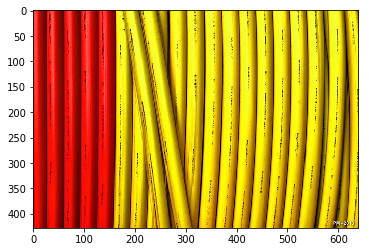

In [52]:
pipes = cv2.imread('photos/pipes.jpg', 1)
print(len(cv2.split(pipes))) # color/B&W
b,g,r = cv2.split(pipes)
pipes = cv2.merge((r,g,b))
plt.imshow(pipes)

In [5]:
# Format
shape_ratio = pipes.shape[0]/pipes.shape[1]
shape_ratio

0.66875

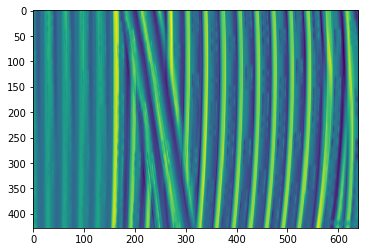

In [6]:
gray = cv2.cvtColor(pipes, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (11,11), 5, borderType=cv2.BORDER_REPLICATE)
plt.imshow(cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3))

In [23]:
# Verticality coef
np.mean(cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3))

1.2904352

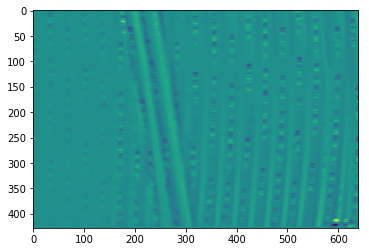

In [7]:
plt.imshow(cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3))

In [24]:
# Horizontality coef
np.mean(cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3))

-0.5474153

In [20]:
# Get the dominant color HSV
N_pixels = pipes.shape[0]*pipes.shape[1]
array = pipes.reshape(N_pixels, 3).astype(float)
codes, dist = scipy.cluster.vq.kmeans(array, 3)
vecs, dist = scipy.cluster.vq.vq(array, codes)
counts, bins = scipy.histogram(vecs, len(codes))
score = counts.astype('float')
index_max = scipy.argmax(score)
main_color = codes[index_max]
h, s, v = rgb2hsv(main_color[0], main_color[1], main_color[2])
print(h, s, v)

In [91]:
# Number of colors
img = Image.fromarray(pipes)
N = 50
img = img.resize((int(N*shape_ratio), N))
N_pixels = int(shape_ratio*N)*N
array = np.asarray(img)
array = array.reshape(N_pixels, 3).astype(float)
clustering = MeanShift().fit(array)
labels = pd.Series(clustering.labels_).value_counts()
N_colors = len(labels)
N_colors